# Motivación para usar métodos Monte Carlo

En un problema que estamos resolviendo con estadística bayesiana cuando tenemos la posterior $P(\lambda|O)$, donde $\lambda$ representa un parámetro que queremos estimar y $O$ representa las observaciones disponibles, una de las primeras cantidades que queremos calcular es el valor esperado de $\lambda$:

$$
\langle \lambda \rangle = \int \lambda P(\lambda|O) d\lambda.
$$

En casos sencillos esta integral se puede resolver analíticamente pero en casos más complejos se debe hacer de manera numérica.
Si $\lambda$ representa un parámetro unidimensional el cálculo numérico de la integral se puede hacer a través del métodos que discretizan la variable de integración en $N$ puntos para aproximar la integral como la suma de área de polígonos (i.e. el método del trapecio).

Pero esta metodología no va a funcionar numéricamente para altas dimensiones. Si tenemos $m$ diferentes dimensiones y discretizamos cada dimensión en $N$ puntos. Esto implicaría evaluar la función a integrar en $N^d$ puntos; con $N=100$ y $d=10$ el problema se vuelve rápidamente incontrolable. La solución a este problema es hacer integración por métodos Monte Carlo. 

## Ejemplo

Pensemos en el ejemplo concreto de la función $f(x)=\exp(x)$ que quisiéramos integrar entre $0\leq x\leq 1$ con métodos Monte Carlo.

En este caso la integral se va a aproximar de la siguiente manera

$$
\int_0^1 \exp(x) dx \approx \sum_{i=1}^{N} f(x_i)\Delta x \approx \frac{x_{\rm max}-x_{\rm min}}{N} \sum_{i=1}^{N} f(x_i) \approx \frac{1}{N} \sum_{i=1}^{N} f(x_i)
$$

Lo interesante del método Monte Carlo de integración es que los $x_i$ no deben estar equiespaciados. Es suficiente con que vengan
de una distribución de probabilidad uniforme entre $x_{\rm min}$ y $x_{\rm max}$.

Comparemos los resultados de la integración por Monte Carlo con el resultado analítico $\int_0^1 \exp(x) dx=e^{1}-1$

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return np.exp(x)

def integral_analitica():
    return np.exp(1) - 1

def integral_monte_carlo(N=100):
    x = np.random.random(N)
    return np.sum(f(x))/N


n_intentos = 10
puntos = np.int_(np.logspace(1,5,n_intentos))
diferencias = np.ones(n_intentos)
for i in range(n_intentos):
    a = integral_analitica()
    b = integral_monte_carlo(N=puntos[i])
    diferencias[i] =  (np.abs((a-b)/a))

Text(0, 0.5, 'Diferencia porcentual Monte Carlo vs. Analitica')

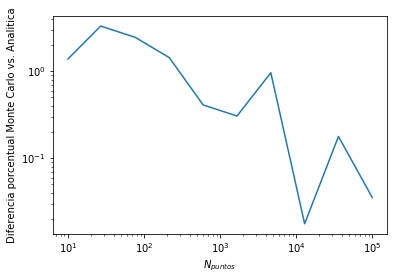

In [3]:
plt.plot(puntos, diferencias*100)
plt.loglog()
plt.xlabel("$N_{puntos}$")
plt.ylabel("Diferencia porcentual Monte Carlo vs. Analitica")

En este ejemplo vemos que si queremos tener una integral con $1\%$ de precisión lo podemos lograr con cerca de $30000$ puntos.

### Ejercicio 1.1

Calcule la integral $\int_0^1 \sin(x)dx$ con el método Monte Carlo y produzca una gráfica como la anterior
donde se muestra la diferencia porcentual entre la solución analítica y numérica como función del número de puntos.

# Integrando con distribuciones no uniformes

En el ejemplo anterior utilizamos puntos que tienen una distribución uniforme para integrar la función exponencial.
En general es posible utilizar puntos que siguen una distribución $g(x)$ para integrar una función $f(x)$.

Escrito en forma de ecuaciones la siguiente identidad es válida

$$
\frac{\int g(x)f(x)dx}{\int g(x)dx} = \langle f(x)\rangle \approx \frac{1}{N}\sum_{i=1}^{N}f(x_i)
$$

donde $g(x)$ representa una distribución de densidad de probabilidad que puede no estar normalizada. Si estuviera normalizada la integral
del denominador sería igual a uno.


# Ejemplo 

Supongamos que queremos calcular la integral $\int_0 ^{\infty} e^{-x} \sin(x) dx$ con el método Monte Carlo.
Para esto sería suficiente generar puntos que sigan la distribución de densidad de probabilidad $e^{-x}$ entre 0 e infinito
y luego calcular el valor promedio de $\sin(x)$ sobre esos puntos.

In [6]:
def f(x):
    return np.sin(x)

def integral_analitica():
    return 0.5

def integral_monte_carlo(N=100):
    x = np.random.exponential(size=N) # esto ya no es una distribucion uniforme!
    return np.sum(f(x))/N


n_intentos = 30
puntos = np.int_(np.logspace(1,5,n_intentos))
diferencias = np.ones(n_intentos) # aqui guardaremos la diferencia entre la sol. numerica y la analitica
for i in range(n_intentos):
    a = integral_analitica()
    b = integral_monte_carlo(N=puntos[i])
    diferencias[i] =  (np.abs((a-b)/a))

Text(0, 0.5, 'Diferencia porcentual Monte Carlo vs. Analitica')

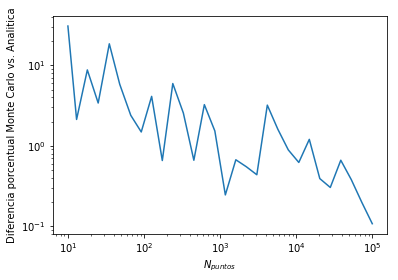

In [7]:
plt.plot(puntos, diferencias*100)
plt.loglog()
plt.xlabel("$N_{puntos}$")
plt.ylabel("Diferencia porcentual Monte Carlo vs. Analitica")

### Ejercicio 1.2

Calcule la integral $\int_0^{\pi/2} x \sin(x)dx$ con un método Monte Carlo y prepare una gráfica similar a la del Ejemplo 1.2.

# Metropolis Hastings

En esta sección vamos a ver tres métodos diferentes para generar una muestra de
puntos que sigan una distribución determinada y así motivar el uso del algoritmo Metropolis-Hastings
La función de distribución que vamos a utilizar es $\frac{1}{2}\sin(x)$ en el intervalo $0<x<\pi$.

Primero vamos a visualizar la forma de esta función

In [9]:
n_puntos=1000
x = np.linspace(0, np.pi)
def f(x):
    y = 0.5 * np.sin(x)
    if(np.isscalar(x)):# esto va a funcionar si entra un numero
        if (x>np.pi) | (x<0):
            y = 0
    else: #esto va a funcionar si entra un array
        ii = (x>np.pi) | (x<0)
        y[ii] = 0.0
    return y

Text(0, 0.5, 'PDF(x)')

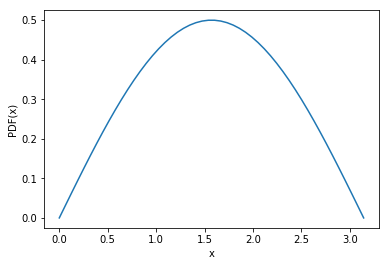

In [10]:
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('PDF(x)')

# Fuerza Bruta

El primer método que vamos a utlizar para generar $N$ puntos que sigan esta distribución es fuerza bruta.

Vamos a generar un punto $x_i$ de una distribución uniforme entre $0$ y $\pi$. Luego para cada punto $x_i$ generamos un segundo n\'umero aleatorio $y_i$ de una distribuci\'on uniforme entre $0$ y el m\'aximo de $f(x)$ (que en este caso es 0.5) y nos preguntamos si $y_i<f(x_i)$; en caso afirmativo entonces incluimos a $x_i$ en la lista, en caso negativo descartamos a $x_i$.

Escrito en código este metodo se ve asi

In [12]:
N = 100000

n_adentro = 0
n_intentos = 0
lista = []
while n_adentro < N:
    x_i = np.random.random()*np.pi
    y_i = np.random.random()*1/2
    n_intentos += 1
    if(y_i < f(x_i)):
        lista.append(x_i)
        n_adentro +=1 

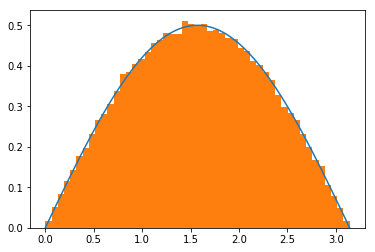

In [13]:
plt.plot(x, f(x))
_ = plt.hist(lista, density=True, bins=x)

El problema es que tuvimos que generar muchos mas numeros (`n_intentos`) de los que al final 
terminaron en la lista `n_adentro`

In [14]:
print(n_adentro/n_intentos)

0.637905628241358


In [28]:
def f(x,alpha,beta):
    return x**(alpha-1.0)*(1.0-x)**(beta-1.0)
def expinv(x,Lambda):
    return np.exp(-Lambda/x)/(x*x)

acceptance ratio 0.30682


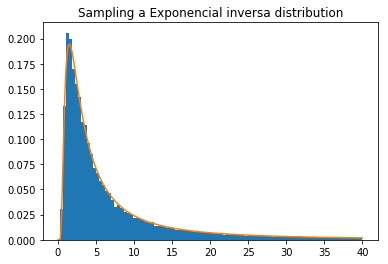

In [31]:
N=10**5
x= np.array([0.0]*N)
alpha=2
beta= 3
# d=0.2
Lambda=3
x[0]=0.5
rhox= np.arange(0.01,40,0.01)
distr = expinv(rhox,Lambda)
norm = np.trapz(distr,rhox)
distr = (1.0/norm)*(distr)
counter = 0
for it in range(1,N,1):
    x_next = 40*np.random.uniform()#x[it-1] + (np.random.uniform()-0.5)*2*d
    
    F = expinv(x_next,Lambda)/expinv(x[it-1],Lambda)
    if F>=1:
        ## se acepta el movieminto
        counter += 1
        x[it]=x_next
        counter +=1
    else:
        if np.random.uniform() < F:
            x[it] = x_next
        else:
            x[it] = x[it-1]

print("acceptance ratio", 1.0*counter/N)
plt.hist(x,bins=100,density = True)
plt.plot(rhox,distr)
plt.title("Sampling a Exponencial inversa distribution")
plt.show()

# Integración analítica

El segundo método utiliza la integral cumulativa  $g(x) = \int_0^x f(y)dy$ que por definición se
encuentra entre 0 y 1. En nuestro ejemplo tenemos $g(x)=-\frac{1}{2}\cos(x) + \frac{1}{2}$

In [15]:
def cumul_f(x):
    return - 0.5 * np.cos(x) + 0.5

Text(0, 0.5, 'PDF(x) cumulativa')

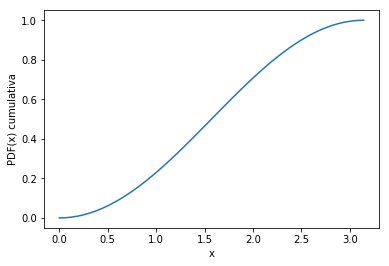

In [16]:
plt.plot(x, cumul_f(x))
plt.xlabel('x')
plt.ylabel('PDF(x) cumulativa')

Si generamos puntos $z_i$ con una distribucion uniforme entre 0 y 1, y calculamos $x_i=g^{-1}(z_i)$ todos los $x_i$ van a seguir la distribucion $f(x)$.

En nuestro caso $g^{-1}(x)$ es $\arccos(-2.0(x-\frac{1}{2}))$

In [17]:
def inversa_cumul_f(x):
    return np.arccos(-2.0*(x-0.5))

Text(0, 0.5, 'Inversa de la PDF(x) cumulativa')

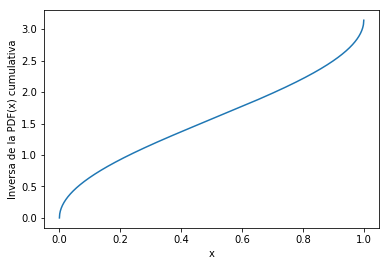

In [18]:
z = np.linspace(0,1.0, n_puntos)
plt.plot(z, inversa_cumul_f(z))
plt.xlabel('x')
plt.ylabel('Inversa de la PDF(x) cumulativa')

In [19]:
#De esta manera solamente tenemos que calcular

N = 100000
z = np.random.random(N)
lista = inversa_cumul_f(z)

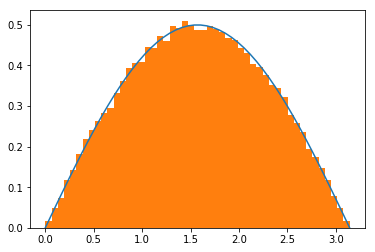

In [20]:
plt.plot(x, f(x))
_ = plt.hist(lista, density=True, bins=x)

La desventaja de este metodo es que solamente es util si podemos integrar e invertir analiticamente la funcion de distribucion.

# Metropolis Hastings

Este algoritmo evita los problemas de los dos metodos anteriores.
Primero, para generar N no voy a desperdiciar intentos; y segundo, no voy a necesitar una integral 
analitica de la distribución que necesito muestrear.

En este algoritmo tengos los siguiente pasos:

0. empiezo con un número aleatorio $x_1$ que se encuentra en el rango de la PDF (puede venir de una distribución uniforme.)
1. propongo un número $x_{2}$ que viene de $x_{1}$ pero con un salto $\delta x$, $x_{2}=x_{1}+\delta_x$. Usualmente este $\delta_x$ es un número aleatorio que viene de una gaussiana centrada en cero y desviación estándar $\sigma$. 
2. Comparo la función de distribución en los dos puntos $r=f(x_{2})/f(x_{1})$.
3. Genero  un número aleatorio $\alpha$ de una distribución uniforme entre 0 y 1.
4. Comparo $\alpha$ con $r$, si $\alpha>r$ entonces incluyo el punto $x_2$ en mi lista, en el caso contrario incluyo a $x_{1}$ en la lista. 

Los pasos 1 a 4 se repiten hasta tener $N$ puntos en mi lista.

Escrito en código tenemos lo siguiente:

In [21]:
N = 100000
lista = [np.random.random()*np.pi]
sigma_delta = 1.0

for i in range(1,N):
    propuesta  = lista[i-1] + np.random.normal(loc=0.0, scale=sigma_delta)
    r = min(1,f(propuesta)/f(lista[i-1]))
    alpha = np.random.random()
    if(alpha<r):
        lista.append(propuesta)
    else:
        lista.append(lista[i-1])

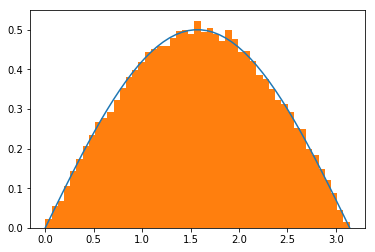

In [22]:
plt.plot(x, f(x))
_ = plt.hist(lista, density=True, bins=x)

# Ejercicio 2.1

Muestree con Metrópolis Hastings la misma distribución que hemos venido utilizando hasta ahora en dos condiciones diferentes:

1. `sigma_delta=0.001`
2. `sigma_delta=1000.0`

Prepare gráficas para los dos casos. ¿Cómo explicaría la diferencia entre las dos situaciones?